# AQI Predictor - Exploratory Data Analysis

In [16]:
# %%
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
import joblib
import shap
from dotenv import load_dotenv

# Load Environment Variables
load_dotenv()

# Configuration
MONGO_URI = os.getenv('MONGO_URI')
DB_NAME = "aqi_db"
COLLECTION_NAME = "processed_data"

# Plotting Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


In [17]:
# %%
def load_data_from_mongo():
    print("⏳ Connecting to MongoDB...")
    client = pymongo.MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]
    
    # Fetch all data
    cursor = collection.find()
    df = pd.DataFrame(list(cursor))
    
    if df.empty:
        print("❌ No data found!")
        return None

    # Preprocessing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
    # Drop non-numeric/unnecessary columns for analysis
    drop_cols = ['_id', 'pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'calculated_aqi']
    df_clean = df.drop(columns=drop_cols, errors='ignore')
    
    print(f"✅ Loaded {len(df_clean)} records.")
    return df_clean

# Load the dataframe
df = load_data_from_mongo()

⏳ Connecting to MongoDB...
✅ Loaded 4402 records.


## 1. Data Overview

In [18]:
# Display first few rows
df.head(10)

,aqi,clouds,day,day_of_week,hour,humidity,month,pressure,temperature,wind_direction,...,aqi_lag_1,aqi_lag_6,aqi_lag_24,aqi_roll_mean_24,hour_sin,hour_cos,month_sin,month_cos,wind_sin,wind_cos
date,,,,,,,,,,,,,,,,,,,,,
2025-07-25 00:00:00,111.784925,40.0,25,4,0,83.0,7,996.0,28.37,270.0,...,109.987437,78.927897,93.838197,95.519966,0.000000,1.000000e+00,-0.5,-0.866025,-1.000000e+00,-1.836970e-16
2025-07-25 01:00:00,113.213065,40.0,25,4,1,83.0,7,996.0,28.13,180.0,...,111.784925,85.846781,93.775107,96.329881,0.258819,9.659258e-01,-0.5,-0.866025,1.224647e-16,-1.000000e+00
2025-07-25 02:00:00,115.552261,75.0,25,4,2,83.0,7,995.0,27.91,360.0,...,113.213065,91.335622,93.270386,97.258293,0.500000,8.660254e-01,-0.5,-0.866025,-2.449294e-16,1.000000e+00
2025-07-25 03:00:00,118.433166,75.0,25,4,3,83.0,7,995.0,27.33,250.0,...,115.552261,96.487983,90.157940,98.436427,0.707107,7.071068e-01,-0.5,-0.866025,-9.396926e-01,-3.420201e-01
2025-07-25 04:00:00,120.279899,75.0,25,4,4,83.0,7,995.0,27.45,290.0,...,118.433166,104.028643,90.284120,99.686251,0.866025,5.000000e-01,-0.5,-0.866025,-9.396926e-01,3.420201e-01
2025-07-25 05:00:00,120.181407,75.0,25,4,5,83.0,7,995.0,27.57,220.0,...,120.279899,109.987437,91.861373,100.866253,0.965926,2.588190e-01,-0.5,-0.866025,-6.427876e-01,-7.660444e-01
2025-07-25 06:00:00,116.364824,75.0,25,4,6,83.0,7,995.0,27.75,240.0,...,120.181407,111.784925,95.331330,101.742648,1.000000,6.123234e-17,-0.5,-0.866025,-8.660254e-01,-5.000000e-01
2025-07-25 07:00:00,110.652261,41.0,25,4,7,86.0,7,996.0,28.96,292.0,...,116.364824,113.213065,101.418593,102.127384,0.965926,-2.588190e-01,-0.5,-0.866025,-9.271839e-01,3.746066e-01
2025-07-25 08:00:00,102.551256,57.0,25,4,8,84.0,7,996.0,29.31,223.0,...,110.652261,115.552261,107.968342,101.901672,0.866025,-5.000000e-01,-0.5,-0.866025,-6.819984e-01,-7.313537e-01


In [19]:
# Basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:")
print(df.dtypes)

Dataset Info:
Shape: (4402, 21)

Columns: ['aqi', 'clouds', 'day', 'day_of_week', 'hour', 'humidity', 'month', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_24', 'aqi_roll_mean_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_sin', 'wind_cos']

Data Types:
aqi                 float64
clouds              float64
day                   int64
day_of_week           int64
hour                  int64
humidity            float64
month                 int64
pressure            float64
temperature         float64
wind_direction      float64
wind_speed          float64
aqi_lag_1           float64
aqi_lag_6           float64
aqi_lag_24          float64
aqi_roll_mean_24    float64
hour_sin            float64
hour_cos            float64
month_sin           float64
month_cos           float64
wind_sin            float64
wind_cos            float64
dtype: object


In [20]:
# Statistical summary
df.describe()

,aqi,clouds,day,day_of_week,hour,humidity,month,pressure,temperature,wind_direction,...,aqi_lag_1,aqi_lag_6,aqi_lag_24,aqi_roll_mean_24,hour_sin,hour_cos,month_sin,month_cos,wind_sin,wind_cos
count,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,...,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4.402000e+03,4.402000e+03,4.402000e+03,4402.000000,4402.000000
mean,203.120646,22.739826,15.861199,3.018401,11.511358,65.846687,8.743753,1011.072519,23.915756,231.976213,...,203.099417,202.981842,202.636996,202.874894,-0.002101,1.893624e-03,-4.906708e-01,3.855156e-01,-0.432036,-0.049844
std,115.178666,25.823551,8.786392,2.000654,6.931874,12.645431,3.265672,7.609552,5.694108,80.273256,...,115.187220,115.248747,115.448504,106.200140,0.707023,7.073452e-01,5.122192e-01,5.902458e-01,0.673374,0.598007
min,34.416667,0.000000,1.000000,0.000000,0.000000,34.000000,1.000000,993.000000,10.990000,0.000000,...,34.416667,34.416667,34.416667,62.513773,-1.000000,-1.000000e+00,-1.000000e+00,-8.660254e-01,-1.000000,-1.000000
25%,117.614447,5.447895,8.000000,1.000000,5.250000,56.000000,8.000000,1004.125000,19.220252,180.000000,...,117.559045,117.189698,116.377136,125.730600,-0.707107,-7.071068e-01,-8.660254e-01,-1.836970e-16,-0.939693,-0.587772
50%,165.514120,13.189639,16.000000,3.000000,12.000000,65.135441,10.000000,1012.523085,23.831536,250.726366,...,165.483140,165.354057,164.915174,165.861999,0.000000,6.123234e-17,-8.660254e-01,5.000000e-01,-0.759914,-0.083481
75%,257.647523,33.718750,23.000000,5.000000,18.000000,74.000000,11.000000,1017.514615,28.439688,291.931457,...,257.647523,257.647523,257.647523,257.782184,0.707107,7.071068e-01,-2.449294e-16,8.660254e-01,0.000000,0.499034
max,500.000000,100.000000,31.000000,6.000000,23.000000,100.000000,12.000000,1023.000000,37.480000,360.000000,...,500.000000,500.000000,500.000000,496.550575,1.000000,1.000000e+00,8.660254e-01,1.000000e+00,1.000000,1.000000


## 2. Missing Values Analysis

In [21]:
# Check for missing values
missing_values = df.isnull().sum()

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values:")
    print(missing_df)
else:
    print("✅ No missing values found!")

✅ No missing values found!


## 3. Target Variable Analysis (AQI)

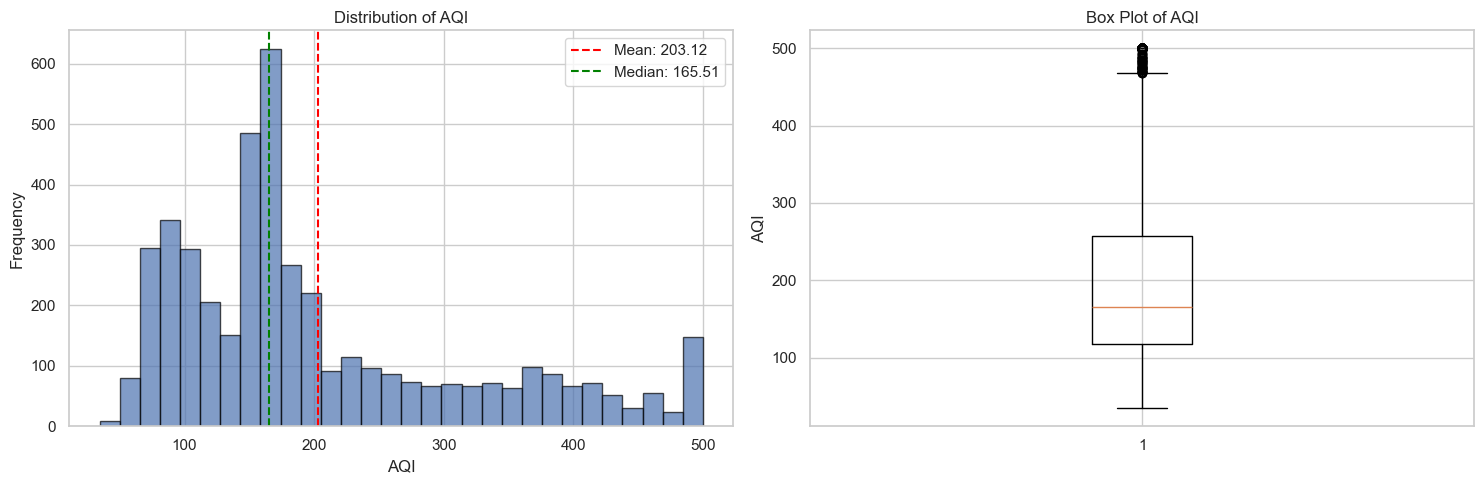

AQI Statistics:
Mean: 203.12
Median: 165.51
Std: 115.18
Min: 34.42
Max: 500.00


In [22]:
# Distribution of AQI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['aqi'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of AQI')
axes[0].set_xlabel('AQI')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['aqi'].mean(), color='red', linestyle='--', label=f'Mean: {df["aqi"].mean():.2f}')
axes[0].axvline(df['aqi'].median(), color='green', linestyle='--', label=f'Median: {df["aqi"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['aqi'], vert=True)
axes[1].set_title('Box Plot of AQI')
axes[1].set_ylabel('AQI')

plt.tight_layout()
plt.show()

print(f"AQI Statistics:")
print(f"Mean: {df['aqi'].mean():.2f}")
print(f"Median: {df['aqi'].median():.2f}")
print(f"Std: {df['aqi'].std():.2f}")
print(f"Min: {df['aqi'].min():.2f}")
print(f"Max: {df['aqi'].max():.2f}")

## 4. Feature Distributions

In [26]:
# Select numeric features for analysis
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove event_id if it's numeric but not a feature
if 'event_id' in numeric_features:
    numeric_features.remove('event_id')

print(f"Numeric features: {numeric_features}")

Numeric features: ['aqi', 'clouds', 'day', 'day_of_week', 'hour', 'humidity', 'month', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_24', 'aqi_roll_mean_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_sin', 'wind_cos']


## 5. Correlation Analysis

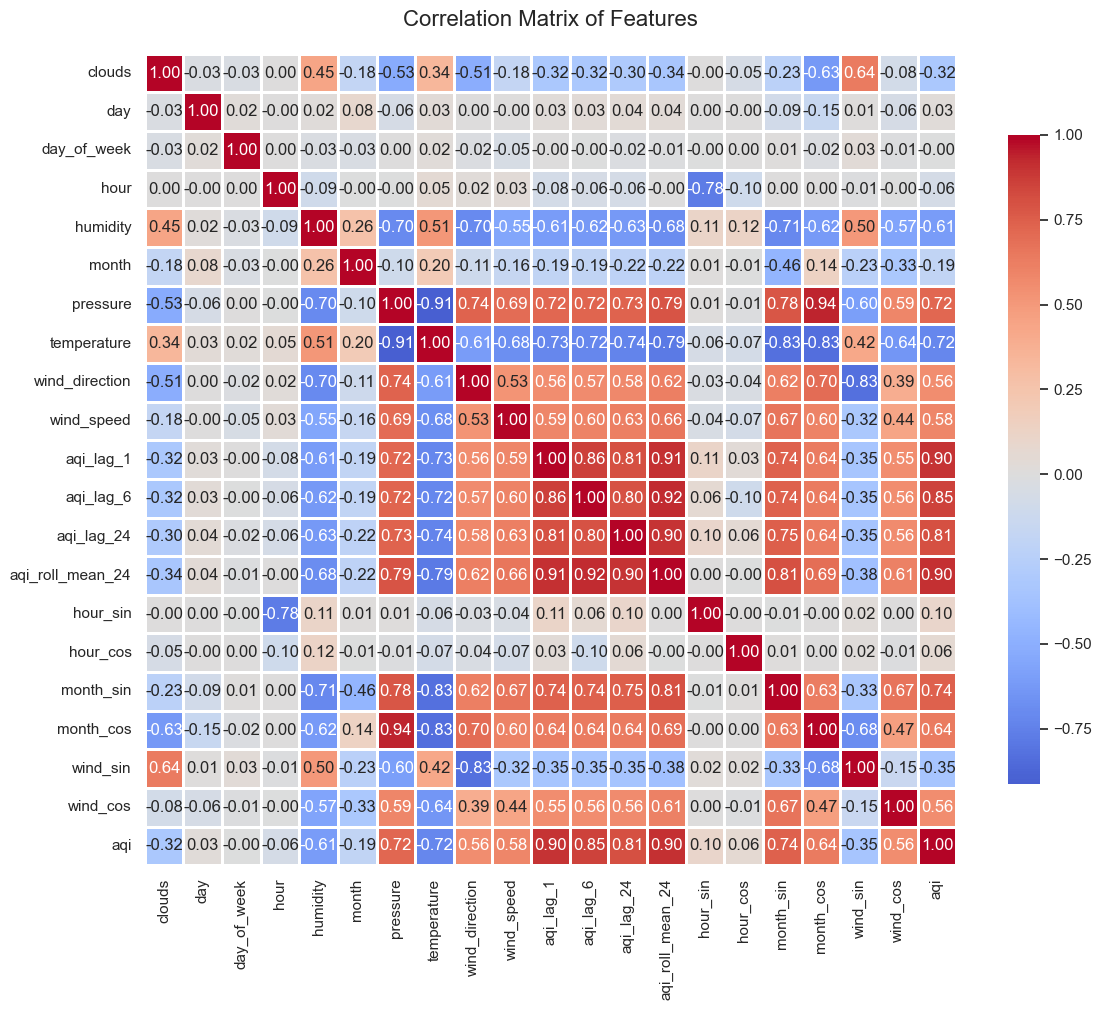

In [27]:
# Calculate correlation matrix for numeric features
correlation_features = numeric_features.copy()
if 'aqi' in correlation_features:
    correlation_features.remove('aqi')
correlation_features.append('aqi')

corr_matrix = df[correlation_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

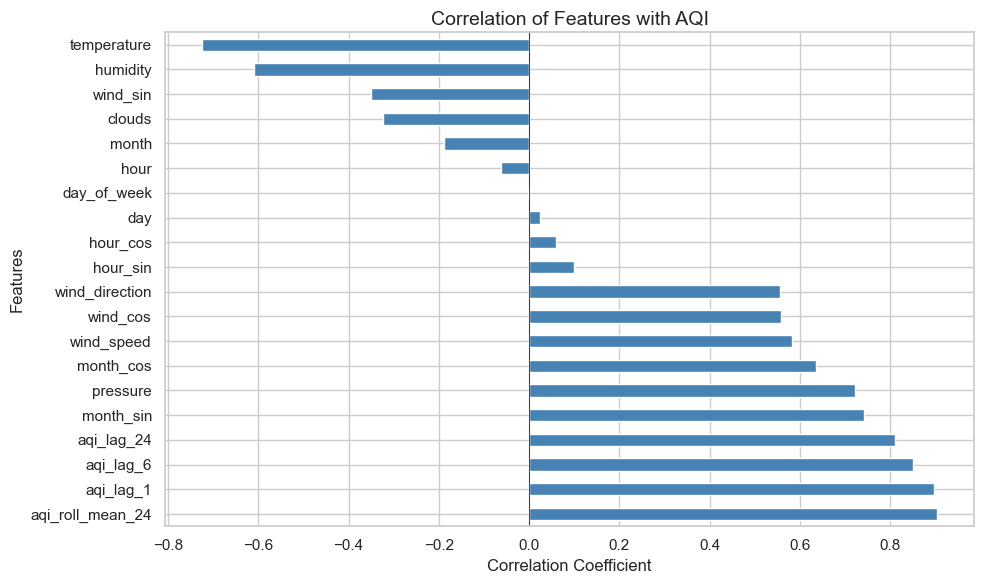


Correlation with AQI:
aqi_roll_mean_24    0.904723
aqi_lag_1           0.898602
aqi_lag_6           0.851283
aqi_lag_24          0.811576
month_sin           0.742563
pressure            0.722719
month_cos           0.636402
wind_speed          0.582966
wind_cos            0.557409
wind_direction      0.555896
hour_sin            0.098880
hour_cos            0.059743
day                 0.025185
day_of_week        -0.001878
hour               -0.062869
month              -0.188822
clouds             -0.323229
wind_sin           -0.350549
humidity           -0.610341
temperature        -0.724952
Name: aqi, dtype: float64


In [28]:
# Correlation with target variable (AQI)
if 'aqi' in df.columns:
    correlations = df[numeric_features].corr()['aqi'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'aqi']
    
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='barh', color='steelblue')
    plt.title('Correlation of Features with AQI', fontsize=14)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelation with AQI:")
    print(correlations)

## 6. Temporal Features Analysis

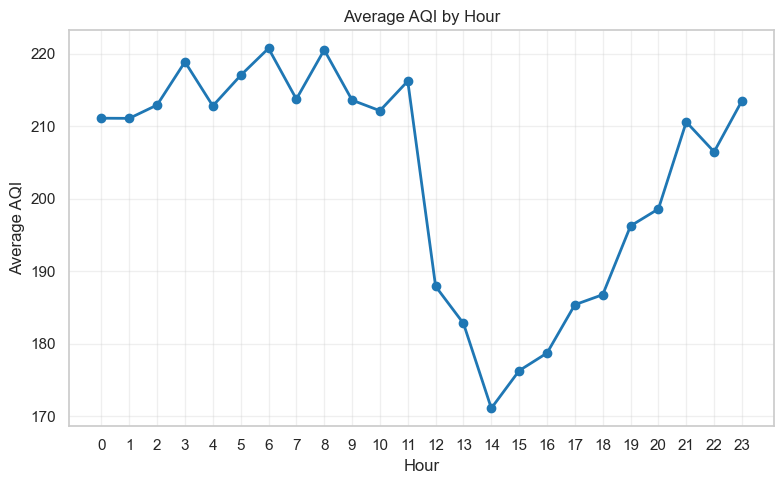

In [40]:
# Analyze AQI by hour
temporal_features = ['hour']
available_temporal = [f for f in temporal_features if f in df.columns]

if len(available_temporal) > 0:
    fig, axes = plt.subplots(1, len(available_temporal), figsize=(8, 5)) # Adjusted figsize for better width
    
    # Handle single plot case
    if len(available_temporal) == 1:
        axes = [axes]
    
    for i, feature in enumerate(available_temporal):
        avg_aqi = df.groupby(feature)['aqi'].mean()
        
        # --- CHANGED TO LINE GRAPH ---
        axes[i].plot(avg_aqi.index, avg_aqi.values, marker='o', linestyle='-', color='tab:blue', linewidth=2)
        
        # Formatting
        axes[i].set_xlabel(feature.capitalize())
        axes[i].set_ylabel('Average AQI')
        axes[i].set_title(f'Average AQI by {feature.capitalize()}')
        axes[i].grid(True, alpha=0.3) # Grid makes line graphs easier to read
        
        # Optional: Ensure all hours (0-23) are shown on X-axis
        if feature == 'hour':
            axes[i].set_xticks(range(0, 24))

    plt.tight_layout()
    plt.show()

## 7. Summary and Insights

In [36]:
print("=" * 60)
print("EDA SUMMARY")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Features: {len(df.columns)}")
print(f"Number of Records: {len(df)}")
print(f"\nMissing Values: {df.isnull().sum().sum()}")
print(f"\nNumeric Features: {len(numeric_features)}")
print(f"\nTarget Variable (AQI) Statistics:")
print(f"  Mean: {df['aqi'].mean():.2f}")
print(f"  Median: {df['aqi'].median():.2f}")
print(f"  Std: {df['aqi'].std():.2f}")
print(f"  Range: {df['aqi'].min():.2f} - {df['aqi'].max():.2f}")

if 'aqi' in df.columns:
    correlations = df[numeric_features].corr()['aqi'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'aqi']
    print(f"\nTop 3 Features Correlated with AQI:")
    for i, (feature, corr) in enumerate(correlations.head(3).items(), 1):
        print(f"  {i}. {feature}: {corr:.3f}")

EDA SUMMARY

Dataset Shape: (4402, 21)
Number of Features: 21
Number of Records: 4402

Missing Values: 0

Numeric Features: 21

Target Variable (AQI) Statistics:
  Mean: 203.12
  Median: 165.51
  Std: 115.18
  Range: 34.42 - 500.00

Top 3 Features Correlated with AQI:
  1. aqi_roll_mean_24: 0.905
  2. aqi_lag_1: 0.899
  3. aqi_lag_6: 0.851
